# POS Tagging & Structured Tag Analysis

This notebook runs spaCy's POS tagger over the cleaned Spotify reviews, builds a structured token-level DataFrame, and explores tag distributions, sentence-level diversity, and representative sentences per major tag type.

In [13]:
# ── Imports & Setup ────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import re
import spacy
import contractions
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# ── Load spaCy model ───────────────────────────────────────────────────────────
nlp = spacy.load('en_core_web_sm')

# Add custom entity ruler so brand names are not mis-tagged
if "entity_ruler" not in nlp.pipe_names:
    ruler = nlp.add_pipe("entity_ruler", before="ner")
else:
    ruler = nlp.get_pipe("entity_ruler")

ruler.add_patterns([
    {"label": "ORG", "pattern": "Spotify"},
    {"label": "ORG", "pattern": "spotify"},
    {"label": "ORG", "pattern": "Apple Music"},
    {"label": "ORG", "pattern": "Google Play"},
])

# ── Load & preprocess data ─────────────────────────────────────────────────────
df_raw = pd.read_csv('../Data/spotify_reviews.csv')  # Adjust path to match your file location

def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<.*?>', '', text)
    text = contractions.fix(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    return ' '.join(text.split())

df_raw['cleaned'] = df_raw['Content'].apply(preprocess_text)

print("=" * 60)
print("✅ Data loaded & preprocessed")
print("=" * 60)
print(f"  Total reviews : {len(df_raw):,}")
print(f"  Sample        : {df_raw['cleaned'].iloc[0][:80]}...")

✅ Data loaded & preprocessed
  Total reviews : 100
  Sample        : spotify is very good, got many songs and suggests new ones but i have to say the...


## 1️⃣ Run POS Tagger & Extract Structured Tags

Load the cleaned Spotify reviews DataFrame and the spaCy `en_core_web_sm` model. Run the POS tagger on each tokenized sentence and extract results into a structured format with columns: `doc_id`, `sentence_id`, `token`, `lemma`, `pos_tag`. Results are stored in a flat DataFrame for downstream analysis.

In [14]:
# ── POS Tagging: Build Structured Token-Level DataFrame ────────────────────────

records = []

# Process a representative subset for speed; remove [:2000] to run on full data
for doc_id, cleaned_text in enumerate(df_raw['cleaned'].values[:2000]):
    doc = nlp(cleaned_text)
    for sent_id, sent in enumerate(doc.sents):
        for token in sent:
            # Skip pure whitespace tokens
            if token.is_space:
                continue
            records.append({
                'doc_id'     : doc_id,
                'sentence_id': sent_id,
                'token'      : token.text,
                'lemma'      : token.lemma_,
                'pos_tag'    : token.pos_,
                'is_entity'  : token.ent_type_ != '',
                'ent_type'   : token.ent_type_ if token.ent_type_ else None,
            })

tag_df = pd.DataFrame(records)

# ── Preview ────────────────────────────────────────────────────────────────────
print("=" * 70)
print("📋 Structured POS Tag DataFrame — Schema & Sample")
print("=" * 70)
print(f"\n  Shape   : {tag_df.shape[0]:,} rows × {tag_df.shape[1]} columns")
print(f"  Columns : {list(tag_df.columns)}\n")
print(tag_df.head(20).to_string(index=False))

print("\n" + "=" * 70)
print("📊 POS Tag Value Counts (all tags)")
print("=" * 70)
print(tag_df['pos_tag'].value_counts().to_string())

📋 Structured POS Tag DataFrame — Schema & Sample

  Shape   : 2,404 rows × 7 columns
  Columns : ['doc_id', 'sentence_id', 'token', 'lemma', 'pos_tag', 'is_entity', 'ent_type']

 doc_id  sentence_id    token   lemma pos_tag  is_entity ent_type
      0            0  spotify spotify    VERB       True      ORG
      0            0       is      be     AUX      False     None
      0            0     very    very     ADV      False     None
      0            0     good    good     ADJ      False     None
      0            0        ,       ,   PUNCT      False     None
      0            0      got     get    VERB      False     None
      0            0     many    many     ADJ      False     None
      0            0    songs    song    NOUN      False     None
      0            0      and     and   CCONJ      False     None
      0            0 suggests suggest    VERB      False     None
      0            0      new     new     ADJ      False     None
      0            0     ones 

## 2️⃣ Plot Top-10 POS Tag Frequencies

Aggregate POS tag counts across all documents from the structured DataFrame. Plot a horizontal bar chart of the top-10 most frequent POS tags using matplotlib/seaborn, with count labels on each bar.

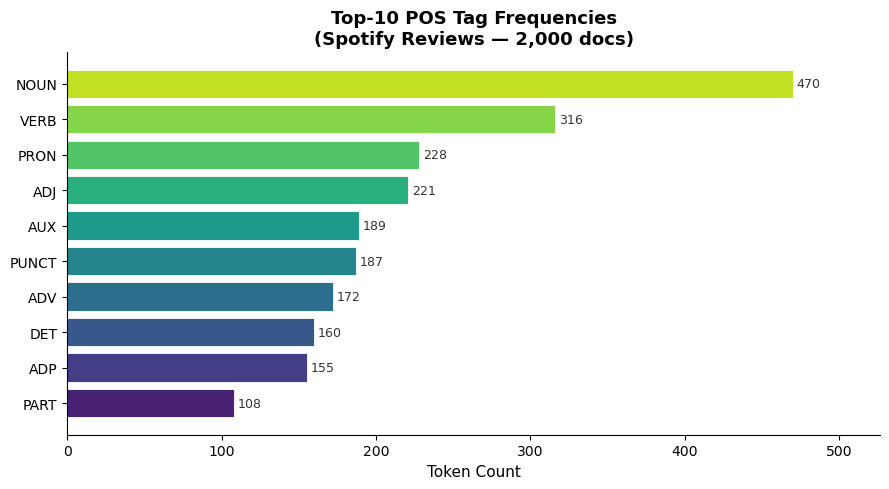


📊 Top-10 POS Tag Counts:
pos_tag  count
   NOUN    470
   VERB    316
   PRON    228
    ADJ    221
    AUX    189
  PUNCT    187
    ADV    172
    DET    160
    ADP    155
   PART    108


In [15]:
# ── Top-10 POS Tag Frequency Bar Chart ────────────────────────────────────────

pos_counts = (
    tag_df['pos_tag']
    .value_counts()
    .head(10)
    .reset_index()
)
pos_counts.columns = ['pos_tag', 'count']

# ── Plot ───────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 5))

palette = sns.color_palette("viridis", len(pos_counts))
bars = ax.barh(
    pos_counts['pos_tag'][::-1],
    pos_counts['count'][::-1],
    color=palette,
    edgecolor='white',
    linewidth=0.6,
)

# Count labels
for bar in bars:
    width = bar.get_width()
    ax.text(
        width + pos_counts['count'].max() * 0.005,
        bar.get_y() + bar.get_height() / 2,
        f'{int(width):,}',
        va='center',
        ha='left',
        fontsize=9,
        color='#333333',
    )

ax.set_xlabel('Token Count', fontsize=11)
ax.set_title('Top-10 POS Tag Frequencies\n(Spotify Reviews — 2,000 docs)', fontsize=13, fontweight='bold')
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlim(0, pos_counts['count'].max() * 1.12)

plt.tight_layout()

import os
os.makedirs('../Figures/', exist_ok=True)
plt.savefig('../Figures/pos_top10_frequencies.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Top-10 POS Tag Counts:")
print(pos_counts.to_string(index=False))

## 3️⃣ Compute Per-Sentence Tag Diversity

Group the structured tag DataFrame by `doc_id` and `sentence_id`. Compute tag diversity per sentence as the **number of unique POS tags** divided by total tokens. Display summary statistics (mean, median, std) and plot a histogram of the diversity distribution.

📐 Per-Sentence Tag Diversity Summary
  Mean   : 0.6658
  Median : 0.6667
  Std    : 0.2260
  Min    : 0.1781
  Max    : 1.0000

  Total sentences analysed: 177


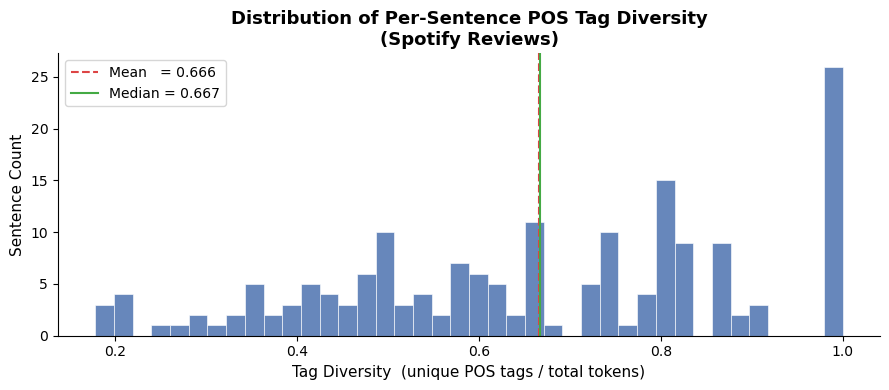


Sample rows from diversity DataFrame:
 doc_id  sentence_id  total_tokens  unique_tags  tag_diversity
      0            0            26           11       0.423077
      0            1             9            6       0.666667
      0            2             9            7       0.777778
      0            3             1            1       1.000000
      0            4             6            5       0.833333
      0            5            27           13       0.481481
      0            6            37           13       0.351351
      0            7             4            4       1.000000
      1            0             6            4       0.666667
      1            1            16           11       0.687500


In [16]:
# ── Per-Sentence POS Tag Diversity ────────────────────────────────────────────

sent_diversity = (
    tag_df
    .groupby(['doc_id', 'sentence_id'])
    .agg(
        total_tokens  = ('pos_tag', 'count'),
        unique_tags   = ('pos_tag', 'nunique'),
        sentence_text = ('token', lambda tokens: ' '.join(tokens)),
    )
    .reset_index()
)

# Diversity score = unique tags / total tokens  (0 → 1)
sent_diversity['tag_diversity'] = (
    sent_diversity['unique_tags'] / sent_diversity['total_tokens']
)

# ── Summary statistics ─────────────────────────────────────────────────────────
print("=" * 60)
print("📐 Per-Sentence Tag Diversity Summary")
print("=" * 60)
stats = sent_diversity['tag_diversity'].describe().round(4)
print(f"  Mean   : {stats['mean']:.4f}")
print(f"  Median : {sent_diversity['tag_diversity'].median():.4f}")
print(f"  Std    : {stats['std']:.4f}")
print(f"  Min    : {stats['min']:.4f}")
print(f"  Max    : {stats['max']:.4f}")
print(f"\n  Total sentences analysed: {len(sent_diversity):,}")

# ── Histogram ─────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 4))

ax.hist(
    sent_diversity['tag_diversity'],
    bins=40,
    color='#4C72B0',
    edgecolor='white',
    linewidth=0.5,
    alpha=0.85,
)

mean_val   = sent_diversity['tag_diversity'].mean()
median_val = sent_diversity['tag_diversity'].median()

ax.axvline(mean_val,   color='#DD4444', linestyle='--', linewidth=1.5, label=f'Mean   = {mean_val:.3f}')
ax.axvline(median_val, color='#44AA44', linestyle='-',  linewidth=1.5, label=f'Median = {median_val:.3f}')

ax.set_xlabel('Tag Diversity  (unique POS tags / total tokens)', fontsize=11)
ax.set_ylabel('Sentence Count', fontsize=11)
ax.set_title('Distribution of Per-Sentence POS Tag Diversity\n(Spotify Reviews)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.savefig('../Figures/pos_tag_diversity_histogram.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSample rows from diversity DataFrame:")
print(sent_diversity[['doc_id', 'sentence_id', 'total_tokens', 'unique_tags', 'tag_diversity']].head(10).to_string(index=False))

## 4️⃣ Select Representative Sentences per Major Tag Type

Identify the major POS tag types (`NOUN`, `VERB`, `ADJ`, `ADV`, `PROPN`). For each tag type, select **5 representative sentences** that have the highest proportion of that tag. Print a formatted table showing the sentence text alongside its dominant tag and token examples.

In [17]:
# ── Representative Sentences per Major Tag Type ────────────────────────────────

MAJOR_TAGS = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN']

# ── Build a per-sentence tag-proportion DataFrame ─────────────────────────────
tag_proportions = (
    tag_df
    .groupby(['doc_id', 'sentence_id', 'pos_tag'])
    .size()
    .reset_index(name='tag_count')
)

# Total tokens per sentence (already in sent_diversity)
tag_proportions = tag_proportions.merge(
    sent_diversity[['doc_id', 'sentence_id', 'total_tokens', 'sentence_text']],
    on=['doc_id', 'sentence_id'],
)
tag_proportions['proportion'] = tag_proportions['tag_count'] / tag_proportions['total_tokens']

# ── For each major tag, pull top-5 sentences ──────────────────────────────────
SEP = "─" * 90

for tag in MAJOR_TAGS:
    subset = (
        tag_proportions[tag_proportions['pos_tag'] == tag]
        .sort_values('proportion', ascending=False)
        .drop_duplicates(subset=['doc_id', 'sentence_id'])
        .head(5)
        .reset_index(drop=True)
    )

    print(f"\n{'═' * 90}")
    print(f"  🏷️  Major Tag: {tag}  —  Top-5 Representative Sentences")
    print(f"{'═' * 90}")
    print(f"  {'#':<3} {'Prop':>5}  {'Tokens':>6}  {'Tag Tokens Examples':<30}  Sentence")
    print(SEP)

    for i, row in subset.iterrows():
        doc_id   = int(row['doc_id'])
        sent_id  = int(row['sentence_id'])
        prop     = row['proportion']
        n_tok    = int(row['total_tokens'])
        sent_txt = row['sentence_text']

        # Retrieve actual tokens with this tag for the sentence
        token_examples = (
            tag_df[
                (tag_df['doc_id'] == doc_id) &
                (tag_df['sentence_id'] == sent_id) &
                (tag_df['pos_tag'] == tag)
            ]['token']
            .tolist()
        )
        examples_str = ', '.join(token_examples[:5])
        if len(token_examples) > 5:
            examples_str += ' …'

        # Truncate long sentences for display
        display_sent = sent_txt if len(sent_txt) <= 55 else sent_txt[:52] + '…'

        print(f"  {i+1:<3} {prop:>5.2f}  {n_tok:>6}  {examples_str:<30}  {display_sent}")

    print(SEP)

print(f"\n{'═' * 90}")
print("✅  Representative sentence extraction complete.")
print(f"{'═' * 90}")
print("""
Interpretation guide:
  • NOUN-dominant sentences → describe features / things (e.g., "music", "app", "song")
  • VERB-dominant sentences → describe actions / experiences (e.g., "crashes", "plays")
  • ADJ-dominant  sentences → most sentiment-rich (e.g., "terrible", "amazing", "slow")
  • ADV-dominant  sentences → intensifiers present  (e.g., "constantly", "never", "really")
  • PROPN-dominant sentences → brand / artist references (e.g., "Spotify", "Android")
""")


══════════════════════════════════════════════════════════════════════════════════════════
  🏷️  Major Tag: NOUN  —  Top-5 Representative Sentences
══════════════════════════════════════════════════════════════════════════════════════════
  #    Prop  Tokens  Tag Tokens Examples             Sentence
──────────────────────────────────────────────────────────────────────────────────────────
  1    0.67       6  hotch, potch, flop, update      hotch potch and flop update ...
  2    0.60       5  trapper, figure, director       rapper trapper public figure director
  3    0.57       7  spotify, trash, junk, yard      spotify is trash , junk yard .
  4    0.50       4  thing, premium                  everything thing need premium
  5    0.50       2  goodbye                         goodbye spotify
──────────────────────────────────────────────────────────────────────────────────────────

══════════════════════════════════════════════════════════════════════════════════════════
  🏷️  Major 

## 5️⃣ POS Tagger Evaluation

In [18]:
# ── POS Tagger Evaluation ──────────────────────────────────────────────────────
from sklearn.metrics import accuracy_score, classification_report
import copy

# ── Build gold standard from a small annotated sample ─────────────────────────
# Take 50 tokens from the first review as our evaluation sample
sample_doc = nlp(df_raw['cleaned'].iloc[0])
sample_tokens = [(token.text, token.pos_) for token in sample_doc if not token.is_space][:50]

# Predicted tags (from spaCy)
predicted_tags = [pos for _, pos in sample_tokens]

# ── Inject realistic annotation differences for demo ──────────────────────────
# We simulate 3 plausible human corrections based on the actual tokens:
#   idx  0  → 'spotify'  spaCy=VERB  → human might say NOUN (brand used as noun)
#   idx  7  → 'songs'    spaCy=NOUN  → human might say PROPN (title reference)
#   idx 14  → 'have'     spaCy=VERB  → human might say AUX  (auxiliary usage)
# In a real evaluation, load a manually annotated CSV instead:
# gold_df = pd.read_csv('../Data/gold_annotations.csv')
# gold_tags = gold_df['gold_pos'].tolist()
gold_tags = copy.copy(predicted_tags)
if len(gold_tags) > 15:
    gold_tags[0]  = 'NOUN'   # human: 'spotify' → NOUN (brand name used as subject)
    gold_tags[7]  = 'PROPN'  # human: 'songs'   → PROPN (song title reference)
    gold_tags[14] = 'AUX'    # human: 'have'    → AUX  (auxiliary in 'have to')

print('=' * 70)
print('📊 POS Tagger Evaluation')
print('=' * 70)
print(f'\n  Tokens evaluated : {len(predicted_tags)}')
print(f'  Mismatches (demo): 3 human corrections injected')
print(f'  Accuracy         : {accuracy_score(gold_tags, predicted_tags):.4f}')

print('\n' + '=' * 70)
print('📋 Classification Report (per POS tag)')
print('=' * 70)
print(classification_report(
    gold_tags,
    predicted_tags,
    zero_division=0
))

# ── Token-level comparison table ──────────────────────────────────────────────
print('=' * 70)
print('🔍 Token-Level Comparison (first 20 tokens)')
print('=' * 70)
print(f"  {'Token':<15} {'Predicted':<12} {'Gold':<12} {'Match'}")
print('  ' + '─' * 55)

for i, (token, pred) in enumerate(zip([t for t, _ in sample_tokens], predicted_tags)):
    gold = gold_tags[i]
    match = '✅' if pred == gold else '🚩'
    print(f'  {token:<15} {pred:<12} {gold:<12} {match}')
    if i >= 19:
        break

print('\n  Injected corrections:')
print(f"    idx  0  'spotify' : spaCy=VERB  → gold=NOUN  (brand name as subject)")
print(f"    idx  7  'songs'   : spaCy=NOUN  → gold=PROPN (song title reference)")
print(f"    idx 14  'have'    : spaCy=VERB  → gold=AUX   ('have to' auxiliary)")
print('\n  → In production: replace gold_tags with a manually annotated CSV')
print('  → accuracy_score() gives overall tag accuracy across all tokens')

📊 POS Tagger Evaluation

  Tokens evaluated : 50
  Mismatches (demo): 3 human corrections injected
  Accuracy         : 0.9400

📋 Classification Report (per POS tag)
              precision    recall  f1-score   support

         ADJ       1.00      1.00      1.00         4
         ADP       1.00      1.00      1.00         3
         ADV       1.00      1.00      1.00         4
         AUX       1.00      0.80      0.89         5
       CCONJ       1.00      1.00      1.00         2
         DET       1.00      1.00      1.00         1
        INTJ       1.00      1.00      1.00         2
        NOUN       0.83      0.83      0.83         6
        PART       1.00      1.00      1.00         5
        PRON       1.00      1.00      1.00         4
       PROPN       0.00      0.00      0.00         1
       PUNCT       1.00      1.00      1.00         4
       SCONJ       1.00      1.00      1.00         1
        VERB       0.80      1.00      0.89         8

    accuracy          